# Capston Project
# Public Safety Using Historical Crime Data and Foursquare Location

# The Crime Data and Foursquare Location Data 

In this Capstone Project we are going to use San Francisco Police Department Incident Reports 2018 - 2019. The dataset has 137301 rows and 34 columns. In our work we are going to use a subset of the whole dataset.

The data has different attributes like the date and time that incident occured, incident number, incident category and subcategory, latitude and longitude of a place incident occured and neighborhood, and so on.

**Here is the dataset we are going to use**

In [2]:
import pandas as pd #Importing Pandas library
import numpy as np
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!pip install lxml #uncomment to install lxml if not installed
#!pip install geopy  #uncomment to install geopy if not installed
import lxml
import requests
from geopy.geocoders import Nominatim
from pandas import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported')

Libraries imported


In [3]:
crime_data = pd.read_csv('San Francisco Police_Department_Incident_Reports__2018_to_Present.csv') #Accesiing the Dataset in csv format
crime_data.head(5)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites)
0,2018/07/18 01:30:00 PM,2018/07/18,13:30,2018,Wednesday,2018/07/18 01:31:00 PM,69250964070,692509,180536729,182001522.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019/04/08 05:25:00 AM,2019/04/08,05:25,2019,Monday,2019/04/13 01:34:00 PM,79165671000,791656,196076240,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019/06/05 02:00:00 PM,2019/06/05,14:00,2019,Wednesday,2019/06/05 02:30:00 PM,81006072000,810060,190416337,191610728.0,...,-122.422464,"(37.78268536745206, -122.42246374465972)",100.0,4.0,11.0,39.0,NaN,NaN,NaN,NaN
3,2019/04/16 08:20:00 PM,2019/04/16,20:20,2019,Tuesday,2019/04/17 12:21:00 AM,79171306244,791713,196076024,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019/06/10 11:00:00 AM,2019/06/10,11:00,2019,Monday,2019/06/10 11:00:00 AM,81012372000,810123,190393440,191521989.0,...,-122.464145,"(37.779090726308574, -122.46414497098554)",5.0,8.0,4.0,11.0,NaN,NaN,NaN,NaN


**Displaying the dataframe columns information using info() method**

In [4]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137301 entries, 0 to 137300
Data columns (total 34 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Incident Datetime                                     137301 non-null  object 
 1   Incident Date                                         137301 non-null  object 
 2   Incident Time                                         137301 non-null  object 
 3   Incident Year                                         137301 non-null  int64  
 4   Incident Day of Week                                  137301 non-null  object 
 5   Report Datetime                                       137301 non-null  object 
 6   Row ID                                                137301 non-null  int64  
 7   Incident ID                                           137301 non-null  int64  
 8   Incident Number                             

**Printing the number of records and columns in a dataframe**

In [5]:
print('The dataset has {} rows and {} columns '.format(crime_data.shape[0], crime_data.shape[1]))

The dataset has 137301 rows and 34 columns 


**Selecting a subset of the dataframe to use in our Capstone Project and start preprocessing**

In [6]:
crime_df = crime_data[['Incident ID','Incident Category',
                     'Police District','Analysis Neighborhood','Latitude','Longitude']]
crime_df = crime_df.dropna(how='any') #Dropping rows with null LAtitudes and Longitudes
crime_df.reset_index(drop=True, inplace=True)
crime_df = crime_df.rename(columns={'Analysis Neighborhood': "Neighborhood"})
crime_df.head(10)

,Incident ID,Incident Category,Police District,Neighborhood,Latitude,Longitude
0,810060,Non-Criminal,Northern,Western Addition,37.782685,-122.422464
1,810123,Non-Criminal,Richmond,Inner Richmond,37.779091,-122.464145
2,810219,Assault,Tenderloin,Tenderloin,37.784449,-122.416072
3,809979,Assault,Ingleside,Outer Mission,37.723168,-122.442554
4,810263,Malicious Mischief,Central,Financial District/South Beach,37.792487,-122.405654
5,810040,Larceny Theft,Park,Haight Ashbury,37.770964,-122.431904
6,810005,Larceny Theft,Park,Castro/Upper Market,37.765323,-122.443538
7,810232,Recovered Vehicle,Richmond,Outer Richmond,37.781677,-122.492375
8,810216,Malicious Mischief,Central,Nob Hill,37.789529,-122.413728
9,810138,Robbery,Bayview,Portola,37.727115,-122.405586


**Correcting misspelled Incident Categories**

In [7]:
crime_df['Incident Category'].replace({'Human Trafficking (A), Commercial Sex Acts':'Human Trafficking, Commercial Sex Acts',
                                        'Motor Vehicle Theft?':'Motor Vehicle Theft',
                                          'Weapons Offence':'Weapons Offense'}, inplace=True)

**Printing the number records and columns after deleting rows with null Latitudes and Longitudes**

In [8]:
print('Now the dataset has {} rows and {} columns '.format(crime_df.shape[0], crime_df.shape[1]))

Now the dataset has 128895 rows and 6 columns 


**Latitude and Longitude for San Francisco**

In [9]:
address = 'San Francisco'
geolocator = Nominatim(user_agent='san_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The latitude and Longitude for San Francisco are {} and {}'.format(latitude, longitude))

The latitude and Longitude for San Francisco are 37.7790262 and -122.4199061


**Selecting sample dataset for mapping**

In [10]:
crime_map_df = crime_df.iloc[0:500]

**Visualizing Police District and Neighborhood using Folium**

In [11]:
san_map = folium.Map(
    location = [latitude, longitude], zoom_start=10
)

for lat, lng, policedistrict, neighborhood in zip(crime_map_df['Latitude'], crime_map_df['Longitude'], crime_map_df['Police District'], crime_map_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, policedistrict)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location = [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(san_map)
    
san_map

**Using aggregate groupby to group  by Neighborhood and count to see which one has high reported crimes**

In [12]:
crime_grp = crime_df.groupby(['Neighborhood']).count()
crime_grp.head(10)

,Incident ID,Incident Category,Police District,Latitude,Longitude
Neighborhood,,,,,
Bayview Hunters Point,7383,7383,7383,7383,7383
Bernal Heights,2169,2169,2169,2169,2169
Castro/Upper Market,4075,4075,4075,4075,4075
Chinatown,2503,2503,2503,2503,2503
Excelsior,2130,2130,2130,2130,2130
Financial District/South Beach,12235,12235,12235,12235,12235
Glen Park,609,609,609,609,609
Golden Gate Park,1343,1343,1343,1343,1343
Haight Ashbury,2106,2106,2106,2106,2106


**Bar chart to visualize reported Incident Categories for each Neighborhood**

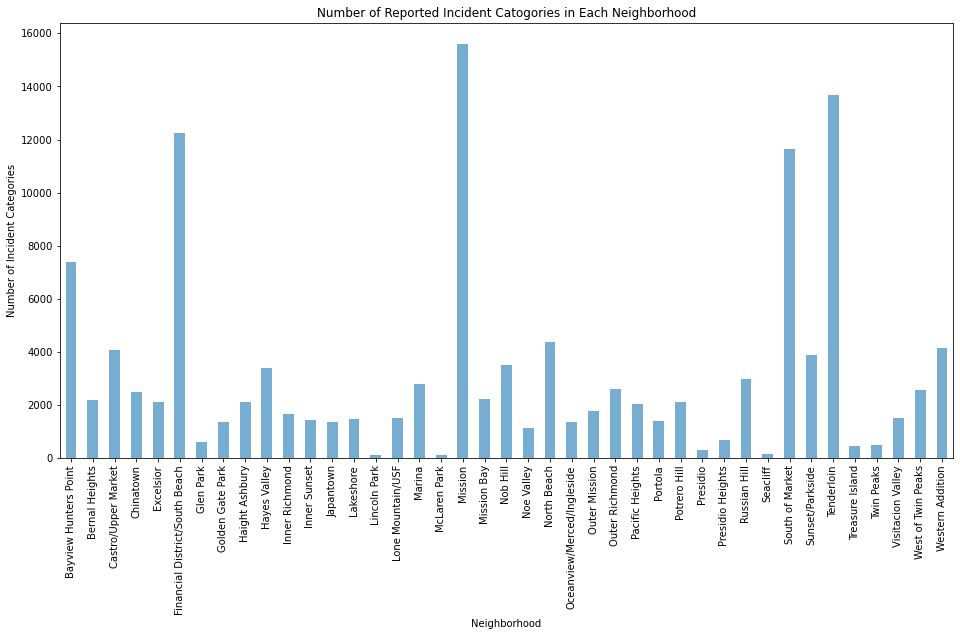

In [13]:
crime_grp['Incident Category'].plot(kind='bar', figsize=(16,8), alpha=0.6)
plt.ylabel('Number of Incident Categories')
plt.title('Number of Reported Incident Catogories in Each Neighborhood')
plt.show()

**Selecting Police Districts with containing Mission to explore and cluster**

In [14]:
mission_only_df = crime_df[crime_df['Police District'].str.contains('Mission')].reset_index(drop=True)

mission_only_df.head(10)

,Incident ID,Incident Category,Police District,Neighborhood,Latitude,Longitude
0,810191,Drug Offense,Mission,Mission,37.764977,-122.420901
1,809916,Warrant,Mission,Castro/Upper Market,37.759830,-122.425920
2,810202,Malicious Mischief,Mission,Mission,37.758633,-122.419053
3,810144,Non-Criminal,Mission,Mission,37.762873,-122.412899
4,810029,Larceny Theft,Mission,Mission,37.768140,-122.422199
5,810247,Missing Person,Mission,Mission,37.756834,-122.406699
6,810088,Offences Against The Family And Children,Mission,Mission,37.757101,-122.417812
7,810080,Malicious Mischief,Mission,Mission,37.766540,-122.422044
8,810208,Lost Property,Mission,Castro/Upper Market,37.760889,-122.435001
9,810063,Motor Vehicle Theft,Mission,Mission,37.764646,-122.426382


**Slicing the dataset of Mission for mapping**

In [15]:
mission_only_map_df = mission_only_df[0:500]
mission_only_map_df.head()

,Incident ID,Incident Category,Police District,Neighborhood,Latitude,Longitude
0,810191,Drug Offense,Mission,Mission,37.764977,-122.420901
1,809916,Warrant,Mission,Castro/Upper Market,37.759830,-122.425920
2,810202,Malicious Mischief,Mission,Mission,37.758633,-122.419053
3,810144,Non-Criminal,Mission,Mission,37.762873,-122.412899
4,810029,Larceny Theft,Mission,Mission,37.768140,-122.422199


**Aggregate of reported incident categories in Police Districts containing the word Mission**

In [16]:
mission_only_grp = mission_only_df.groupby(['Neighborhood']).count()
mission_only_grp.head(10)

,Incident ID,Incident Category,Police District,Latitude,Longitude
Neighborhood,,,,,
Bayview Hunters Point,14,14,14,14,14
Bernal Heights,168,168,168,168,168
Castro/Upper Market,3286,3286,3286,3286,3286
Excelsior,5,5,5,5,5
Financial District/South Beach,9,9,9,9,9
Glen Park,1,1,1,1,1
Haight Ashbury,2,2,2,2,2
Hayes Valley,9,9,9,9,9
Inner Richmond,1,1,1,1,1


**A bar chart visualization for incident categories in Police Districts cotnaining the word Mission**

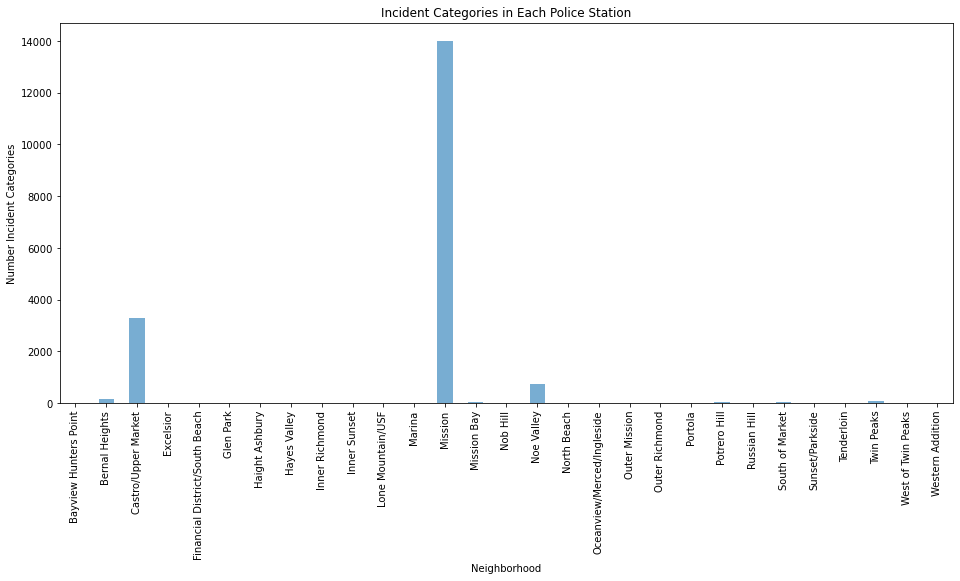

In [17]:
mission_only_grp['Incident Category'].plot(kind='bar', figsize=(16,7), alpha=0.6)
plt.title('Incident Categories in Each Police Station')
plt.ylabel('Number Incident Categories')
plt.show()

**A map to visualize Police District containing Mission**

In [18]:
mission_map = folium.Map(
    location=[latitude, longitude], zoom_start=12
)

for lat, lng, policedistrict, neighborhood in zip(mission_only_map_df['Latitude'], mission_only_map_df['Longitude'], mission_only_map_df['Police District'], mission_only_map_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, policedistrict)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location = [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mission_map)
    
mission_map

**Setting Foursquare credentials**

In [39]:
CLIENT_ID = '1YBHEE5SEGQ5IJT2C4DJ51JQIHJLBV4XDSEHMSI1JX5U5EK5'
CLIENT_SECRET = 'PWUWYE3TAEA0CQGUA1RJATXUOGXDLTORP52SDVSGEUWOERDK'
VERSION = '20201120' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails are: Clent ID - {} and Client Secret - {}'.format(CLIENT_ID, CLIENT_SECRET))

Your credentails are: Clent ID - 1YBHEE5SEGQ5IJT2C4DJ51JQIHJLBV4XDSEHMSI1JX5U5EK5 and Client Secret - PWUWYE3TAEA0CQGUA1RJATXUOGXDLTORP52SDVSGEUWOERDK


**Selecting neighborhood to explore**

In [40]:
neighbor_latitude = mission_only_df.loc[8, 'Latitude']
neighbor_longitude = mission_only_df.loc[8, 'Longitude']
neighbor_name = mission_only_df.loc[8, 'Neighborhood']

print('The latitude and longitude of a {} are {} and {}'.format(neighbor_name, neighbor_latitude, neighbor_longitude))

The latitude and longitude of a Castro/Upper Market are 37.760888932091525 and -122.43500070269909


**Creating a Foursquare query URL to get venues at a radius of 1000 meters**

In [41]:
LIMIT = 100
RADIUS = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighbor_latitude,
    neighbor_longitude,
    RADIUS,
    LIMIT
)

**Querying Foursquare venues for a given neighborhood**

**This is the sample Foursquare location data to be used in our Capstone Project**

In [42]:
venues_result = requests.get(url).json()
venues_result

{'meta': {'code': 200, 'requestId': '5fbc752201f51442ca570e8c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Castro',
  'headerFullLocation': 'Castro, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 159,
  'suggestedBounds': {'ne': {'lat': 37.76988894109154,
    'lng': -122.42363780189312},
   'sw': {'lat': 37.751888923091514, 'lng': -122.44636360350505}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4089ae00f964a520bff21ee3',
       'name': 'Castro Theatre',
       'location': {'address': '429 Castro St',
        'crossStreet': 'btwn 18th & Market',
        'lat': 37.762044145115574,
        'lng': -12

**Extract category of a venue**

In [43]:
def get_category_type(row):
    try:
        category_list = row['categories']
    except:
        category_list = row['venue.categories']
    if len(category_list) == 0:
        return None
    else:
        return category_list[0]['name']

In [44]:
venues = venues_result['response']['groups'][0]['items']
near_by_venues = json_normalize(venues)

#filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
near_by_venues = near_by_venues.loc[:, filtered_columns]

#filter category for each row
near_by_venues['venue.categories'] = near_by_venues.apply(get_category_type, axis=1)

#clean column
near_by_venues.columns = [col.split('.')[-1] for col in near_by_venues.columns]

print('Number of Venues Returned: ', near_by_venues.shape[0])

near_by_venues.head()

Number of Venues Returned:  100


,name,categories,lat,lng
0,Castro Theatre,Indie Movie Theater,37.762044,-122.435022
1,Anchor Oyster Bar,Seafood Restaurant,37.759708,-122.434910
2,Yoga Tree Castro,Yoga Studio,37.761051,-122.436003
3,Philz Coffee,Coffee Shop,37.760120,-122.434760
4,The Castro Fountain,Ice Cream Shop,37.760052,-122.435024


**Retrieving near by venues**

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Search venues in Mission using subset of the mission only data frame**

In [46]:
mission_only_subset_df = mission_only_df[0:500]
mission_only_subset_df.head(10)

,Incident ID,Incident Category,Police District,Neighborhood,Latitude,Longitude
0,810191,Drug Offense,Mission,Mission,37.764977,-122.420901
1,809916,Warrant,Mission,Castro/Upper Market,37.759830,-122.425920
2,810202,Malicious Mischief,Mission,Mission,37.758633,-122.419053
3,810144,Non-Criminal,Mission,Mission,37.762873,-122.412899
4,810029,Larceny Theft,Mission,Mission,37.768140,-122.422199
5,810247,Missing Person,Mission,Mission,37.756834,-122.406699
6,810088,Offences Against The Family And Children,Mission,Mission,37.757101,-122.417812
7,810080,Malicious Mischief,Mission,Mission,37.766540,-122.422044
8,810208,Lost Property,Mission,Castro/Upper Market,37.760889,-122.435001
9,810063,Motor Vehicle Theft,Mission,Mission,37.764646,-122.426382


In [47]:
# type your answer here
mission_only_venues = getNearbyVenues(names=mission_only_subset_df['Neighborhood'],
                                   latitudes=mission_only_subset_df['Latitude'],
                                   longitudes=mission_only_subset_df['Longitude']
                                  )

Mission
Castro/Upper Market
Mission
Mission
Mission
Mission
Mission
Mission
Castro/Upper Market
Mission
Mission
South of Market
Potrero Hill
Mission
Mission
Mission
Noe Valley
Mission
Bernal Heights
Mission
Mission
Noe Valley
Financial District/South Beach
Mission
Castro/Upper Market
Noe Valley
Mission
Mission
Mission
Mission
Bernal Heights
Mission
Noe Valley
Mission
Mission
Mission
Mission
Castro/Upper Market
Castro/Upper Market
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Noe Valley
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Castro/Upper Market
Mission
Mission
Castro/Upper Market
Castro/Upper Market
Castro/Upper Market
Castro/Upper Market
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Noe Valley
Noe Valley
Castro/Upper Market
Mission
Noe Valley
Mission
Mission
Mission
Mission
Castro/Upper Market
Mission
Castro/Upper Market
Mission
Mission
Mission
Mission
Mission
Mission
Mission
Castro/Upper Market
Mission
Castro/Upper Market
Mi

In [49]:
mission_only_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mission,37.764977,-122.420901,The Secret Alley,37.763764,-122.419352,Performing Arts Venue
1,Mission,37.764977,-122.420901,Good Vibrations,37.763195,-122.421735,Adult Boutique
2,Mission,37.764977,-122.420901,Stonemill Matcha,37.763944,-122.421667,Café
3,Mission,37.764977,-122.420901,Monk’s Kettle,37.764750,-122.422922,Gastropub
4,Mission,37.764977,-122.420901,Yoga to the People,37.764887,-122.419062,Yoga Studio


In [50]:
mission_only_encoded = pd.get_dummies(mission_only_venues[['Venue Category']], prefix="", prefix_sep="")  #Encoding
mission_only_encoded['Neighborhood'] = mission_only_venues['Neighborhood']  #Adding neighborhood column
fixed_columns = [mission_only_encoded.columns[-1]] + list(mission_only_encoded.columns[:-1])

mission_only_encoded = mission_only_encoded[fixed_columns]
mission_only_encoded.head()

,Neighborhood,Acai House,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mission,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
mission_only_grouped = mission_only_encoded.groupby(['Neighborhood']).mean().reset_index()
mission_only_grouped.head()

,Neighborhood,Acai House,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Bernal Heights,0.00,0.000000,0.000000,0.006012,0.000000,0.000000,0.000000,0.000000,0.020040,...,0.006012,0.000000,0.000000,0.010020,0.000000,0.000000,0.000000,0.0,0.0,0.018036
1,Castro/Upper Market,0.00,0.001294,0.004118,0.005882,0.001176,0.004235,0.000706,0.001059,0.007059,...,0.001294,0.001176,0.003176,0.003765,0.000000,0.020941,0.002000,0.0,0.0,0.018706
2,Financial District/South Beach,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,...,0.000000,0.000000,0.000000,0.030000,0.010000,0.010000,0.000000,0.0,0.0,0.010000
3,Hayes Valley,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010000,0.000000,0.010000,0.000000,0.040000,0.010000,0.0,0.0,0.010000
4,Mission,0.00,0.002489,0.005862,0.010198,0.002784,0.000080,0.003640,0.004042,0.014346,...,0.001900,0.002944,0.001713,0.005112,0.002275,0.009341,0.003426,0.0,0.0,0.021439


In [53]:
def get_most_common_venues(row, number_top_venues):
    row_categories = row.iloc[1:]
    sorted_row_categories = row_categories.sort_values(ascending=False)
    return sorted_row_categories.index.values[0:number_top_venues]

In [54]:
top_venues = 10
#
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Creating a dataframae 
sorted_mission_neighborhood_venues = pd.DataFrame(columns=columns)
sorted_mission_neighborhood_venues['Neighborhood'] = mission_only_grouped['Neighborhood']

for ind in np.arange(mission_only_grouped.shape[0]):
    sorted_mission_neighborhood_venues.iloc[ind, 1:] = get_most_common_venues(mission_only_grouped.iloc[ind, :], top_venues)
    
sorted_mission_neighborhood_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bernal Heights,Mexican Restaurant,Coffee Shop,Pizza Place,Café,Grocery Store,Cocktail Bar,Italian Restaurant,Bakery,Park,Restaurant
1,Castro/Upper Market,Gay Bar,Coffee Shop,New American Restaurant,Park,Bakery,Thai Restaurant,Cocktail Bar,Wine Bar,Mediterranean Restaurant,Grocery Store
2,Financial District/South Beach,Coffee Shop,Gym,Food Truck,Scenic Lookout,Seafood Restaurant,Park,Vietnamese Restaurant,Japanese Restaurant,Ice Cream Shop,Mediterranean Restaurant
3,Hayes Valley,Wine Bar,French Restaurant,Cocktail Bar,New American Restaurant,Pizza Place,Bakery,Sushi Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant
4,Mission,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery


## Clustering

In [55]:
#Number of clusters
nclusters = 5
clustering_mission_only_grouped = mission_only_grouped.drop(['Neighborhood'], axis=1)

#k-means
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(clustering_mission_only_grouped)
kmeans.labels_[0:20]

array([4, 4, 3, 4, 4, 0, 2, 0, 0, 2, 1], dtype=int32)

In [56]:
sorted_mission_neighborhood_venues.insert(0, 'Cluster Labels', kmeans.labels_)
mission_only_merged = mission_only_subset_df
mission_only_merged = mission_only_merged.join(sorted_mission_neighborhood_venues.set_index('Neighborhood'), on='Neighborhood')
mission_only_merged.head()

,Incident ID,Incident Category,Police District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,810191,Drug Offense,Mission,Mission,37.764977,-122.420901,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
1,809916,Warrant,Mission,Castro/Upper Market,37.759830,-122.425920,4,Gay Bar,Coffee Shop,New American Restaurant,Park,Bakery,Thai Restaurant,Cocktail Bar,Wine Bar,Mediterranean Restaurant,Grocery Store
2,810202,Malicious Mischief,Mission,Mission,37.758633,-122.419053,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
3,810144,Non-Criminal,Mission,Mission,37.762873,-122.412899,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
4,810029,Larceny Theft,Mission,Mission,37.768140,-122.422199,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery


In [57]:
clusters_map = folium.Map(
    location=[latitude, longitude], zoom_start=12
)

x = np.arange(nclusters)
yc = [i + x + (i*x)**2 for i in range(nclusters)]
color_array = cm.rainbow(np.linspace(0, 1, len(yc)))
rainbow = [colors.rgb2hex(i) for i in color_array]

marker_color = []
for lat, lng, neighbor, cluster in zip(mission_only_merged['Latitude'], mission_only_merged['Longitude'], mission_only_merged['Neighborhood'], mission_only_merged['Cluster Labels']):
    label = folium.Popup(str(neighbor) + 'Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        location = [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)
    
clusters_map

#### Examining clusters created

In [66]:
mission_only_merged.loc[mission_only_merged['Cluster Labels'] == 0, mission_only_merged.columns[[2] + list(range(6, mission_only_merged.shape[1]))]]

,Police District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Mission,0,Coffee Shop,Gym,Gym / Fitness Center,Pizza Place,Vietnamese Restaurant,Bakery,Art Gallery,Dance Studio,Marijuana Dispensary,Café
12,Mission,0,Coffee Shop,Café,Park,Sandwich Place,Art Gallery,Brewery,Breakfast Spot,Wine Bar,Gym,Cocktail Bar
97,Mission,0,Coffee Shop,Gym,Gym / Fitness Center,Pizza Place,Vietnamese Restaurant,Bakery,Art Gallery,Dance Studio,Marijuana Dispensary,Café
113,Mission,0,Coffee Shop,Gym,Gym / Fitness Center,Pizza Place,Vietnamese Restaurant,Bakery,Art Gallery,Dance Studio,Marijuana Dispensary,Café
192,Mission,0,Park,Art Gallery,Gym,Coffee Shop,Gym / Fitness Center,Furniture / Home Store,Mexican Restaurant,Café,Sandwich Place,Grocery Store
391,Mission,0,Park,Art Gallery,Gym,Coffee Shop,Gym / Fitness Center,Furniture / Home Store,Mexican Restaurant,Café,Sandwich Place,Grocery Store


In [67]:
mission_only_merged.loc[mission_only_merged['Cluster Labels'] == 1, mission_only_merged.columns[[2] + list(range(6, mission_only_merged.shape[1]))]]

,Police District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
101,Mission,1,Trail,Scenic Lookout,Park,Playground,Bus Line,Bus Stop,Hill,Sandwich Place,French Restaurant,Burger Joint


In [68]:
mission_only_merged.loc[mission_only_merged['Cluster Labels'] == 2, mission_only_merged.columns[[2] + list(range(6, mission_only_merged.shape[1]))]]

,Police District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
21,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
25,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
32,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
47,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
71,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
72,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
75,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio
123,Mission,2,Park,Trail,Scenic Lookout,Gay Bar,Coffee Shop,Hill,Thai Restaurant,Yoga Studio,Bakery,Wine Bar
129,Mission,2,Trail,Coffee Shop,Park,Bakery,Italian Restaurant,Gift Shop,Bookstore,Playground,Café,Yoga Studio


In [69]:
mission_only_merged.loc[mission_only_merged['Cluster Labels'] == 3, mission_only_merged.columns[[2] + list(range(6, mission_only_merged.shape[1]))]]

,Police District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Mission,3,Coffee Shop,Gym,Food Truck,Scenic Lookout,Seafood Restaurant,Park,Vietnamese Restaurant,Japanese Restaurant,Ice Cream Shop,Mediterranean Restaurant


In [70]:
mission_only_merged.loc[mission_only_merged['Cluster Labels'] == 4, mission_only_merged.columns[[2] + list(range(6, mission_only_merged.shape[1]))]]

,Police District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
1,Mission,4,Gay Bar,Coffee Shop,New American Restaurant,Park,Bakery,Thai Restaurant,Cocktail Bar,Wine Bar,Mediterranean Restaurant,Grocery Store
2,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
3,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
4,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
...,...,...,...,...,...,...,...,...,...,...,...,...
494,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
495,Mission,4,Gay Bar,Coffee Shop,New American Restaurant,Park,Bakery,Thai Restaurant,Cocktail Bar,Wine Bar,Mediterranean Restaurant,Grocery Store
496,Mission,4,Mexican Restaurant,Coffee Shop,Cocktail Bar,Café,Bar,Pizza Place,New American Restaurant,Grocery Store,Yoga Studio,Bakery
497,Mission,4,Gay Bar,Coffee Shop,New American Restaurant,Park,Bakery,Thai Restaurant,Cocktail Bar,Wine Bar,Mediterranean Restaurant,Grocery Store
